UAE Foreign Assistance Reports Scraper

https://www.mofa.gov.ae/en/The-Ministry/UAE-International-Development-Cooperation/Annual-Foreign-Aid-Report

In [ ]:
# %pip install pdfplumber
# %pip install pycountry
# %pip install bs4
# %pip install rapidfuzz

In [1]:
import pdfplumber
import pandas as pd
from pathlib import Path
import re
import pycountry
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime
import io
import matplotlib.pyplot as plt

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime

def scrape_reports(start_year=2019, end_year=datetime.now().year):
    """Scrape UAE Foreign Aid Reports and return structured data."""
    base_url = "https://www.mofa.gov.ae"
    reports_url = base_url + "/en/The-Ministry/UAE-International-Development-Cooperation/Annual-Foreign-Aid-Report"

    reports_data = []

    try:
        print("Fetching reports...")
        response = requests.get(reports_url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        report_cards = soup.find_all('div', class_='aegov-card')

        for card in report_cards:
            try:
                # Extract title and year
                title_tag = card.find(['h2', 'h3', 'h4', 'h5', 'h6'])
                if not title_tag:
                    continue

                title = title_tag.get_text(strip=True)
                year = None
                for y in range(start_year, end_year + 1):
                    if str(y) in title:
                        year = y
                        break

                if not year:
                    continue

                # Find all links (View & Download)
                view_links = []
                download_links = []
                for a in card.find_all('a', class_='aegov-link'):
                    href = a['href']
                    if not href.startswith('http'):  # Convert relative URLs
                        href = urljoin(base_url, href)
                    
                    link_text = a.get_text(strip=True).lower()
                    if 'view' in link_text:
                        view_links.append(href)
                    elif 'download' in link_text:
                        download_links.append(href)

                # Store only if there are links
                if view_links or download_links:
                    reports_data.append({
                        'year': year,
                        'title': title,
                        'view_urls': view_links,
                        'download_urls': download_links
                    })

            except Exception as e:
                print(f"Error processing card: {e}")
                continue

        # Sort by year (newest first)
        reports_data.sort(key=lambda x: x['year'], reverse=True)
        return reports_data

    except Exception as e:
        print(f"Scraping failed: {e}")
        return None

In [3]:
import pdfplumber
import re
import io
import requests

def extract_table_text(pdf_source, start_markers, verbose=True):
    if pdf_source.startswith("http"):
        response = requests.get(pdf_source)
        if response.status_code != 200:
            print(f"❌ Failed to access PDF. Status code: {response.status_code}")
            return {}
        if verbose:
            print("🌐 Accessed PDF from URL")
        pdf_file = io.BytesIO(response.content)
    else:
        pdf_file = pdf_source

    start_markers_lc = [s.lower() for s in start_markers]
    current_marker_idx = -1

    skip_keywords = {"appendix", "foreign", "assistance", "least developed", "countries", "uae", "sector"}
    corner_page_number_pattern = re.compile(r"^\d{3}$")

    def looks_like_continuation(line):
        return (not re.search(r"[\d,]", line)) and len(line.strip()) < 40 and line.strip()

    def is_header_noise(line):
        return any(kw in line.lower().strip() for kw in skip_keywords)

    def is_number_line(line):
        return bool(re.search(r"\d", line))

    def is_category_line(line):
        return not is_number_line(line) and not is_header_noise(line)

    def is_pure_numbers_line(line):
        return bool(re.fullmatch(r"[\d\s,]+[-\d\s,]*", line.strip()))

    def drop_suffixes(line):
        return line.replace("Development", "").replace("Supply", "").replace("Assistance", "").replace("Services", "").replace("Society", "").replace("Change", "").replace("Grenadines","").strip()

    results = {}
    collecting = False
    current_lines = []
    current_marker = None

    with pdfplumber.open(pdf_file) as pdf:
        for p_num, page in enumerate(pdf.pages, start=1):
            text_l = (page.extract_text() or "").encode("utf-8", errors="replace").decode("utf-8").lower()
            
            if any(m in text_l for m in start_markers_lc) and "appendix" in text_l and "content" in text_l:
                if verbose:
                    print(f"📄 Page {p_num:>3}: TOC detected → skipped")
                continue

            for idx, marker in enumerate(start_markers_lc):
                if marker in text_l and (idx != current_marker_idx):
                    if collecting and current_marker:
                        results[current_marker] = "\n".join(current_lines)
                        current_lines = []
                        if verbose:
                            print(f"📥 Saved table for marker: {current_marker}")
                    current_marker_idx = idx
                    current_marker = start_markers[idx]
                    collecting = True
                    if verbose:
                        print(f"📄 Page {p_num}: Start of table → {current_marker}")
                    break

            if collecting:
                W, H = page.width, page.height
                col_width = W / 4
                bboxes = [(i * col_width, 0, (i + 1) * col_width, H) for i in range(4)]

                for bbox in bboxes:
                    column = page.within_bbox(bbox)
                    col_text = column.extract_text()
                    if not col_text:
                        continue

                    raw_lines = col_text.split("\n")
                    split_lines = [
                        part.strip()
                        for rl in raw_lines
                        for part in re.split(r"\s{2,}", rl.strip())
                        if part.strip()
                    ]

                    i = 0
                    while i < len(split_lines):
                        line = split_lines[i].strip()

                        if (not line or corner_page_number_pattern.fullmatch(line) or
                            line.lower().startswith("united arab emirates") or
                            line.lower().startswith("foreign aid report")):
                            i += 1
                            continue

                        next_line = split_lines[i + 1].strip() if (i + 1) < len(split_lines) else ""

                        if is_category_line(line) and next_line and is_number_line(next_line):
                            current_lines.append(f"{drop_suffixes(line)} {next_line}")
                            i += 2
                        elif next_line and looks_like_continuation(next_line):
                            current_lines.append(drop_suffixes(f"{line} {next_line}").strip())
                            i += 2
                        else:
                            current_lines.append(drop_suffixes(line).strip())
                            i += 1

            if collecting and "grand total" in text_l:
                if current_marker:
                    results[current_marker] = "\n".join(current_lines)
                    if verbose:
                        print(f"🏁 Page {p_num}: 'Grand Total' reached → Saved: {current_marker}")
                collecting = False
                current_marker = None
                current_marker_idx = -1
                current_lines = []

    # Final cleanup with category fixing
    for marker in results:
        raw_text = results[marker]
        lines = raw_text.splitlines()
        cleaned_lines = []
        
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            
            if "grand total" in line.lower():
                if verbose:
                    print(f"🔍 Cleanup: Stopping at 'Grand Total' for {marker}")
                break  # Stop processing further lines after "Grand Total"
            
            if len(line) > 3 and not any(
                keyword in line.lower() for keyword in (
                    "united arab emirates", "foreign", "countries",
                    "least", "appendi", "countries", "land-locked", 'sector',
                    'developing',
                )
            ):
                if "Construction and Civil" in line:
                    new_line = line.replace("Construction and Civil", "\nConstruction and Civil Development")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line)
                elif "General Programme" in line:
                    new_line = line.replace("General Programme", "General Programme Assistance")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".",""))
                elif "Energy Generation and" in line:
                    new_line = line.replace("Energy Generation and", "Energy Generation and Supply")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".",""))
                elif "Banking and Financial" in line:
                    new_line = line.replace("Banking and Financial", "Banking and Financial Services")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".",""))
                elif "Social Services" in line:
                    cleaned_lines.append(new_line.replace(".",""))
                elif "Government and Civil" in line:
                    new_line = line.replace("Government and Civil", "Government and Civil Society")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".",""))
                elif "Environment and Climate" in line:
                    new_line = line.replace("Environment and Climate", "Environment and Climate Change")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".",""))
                elif "Republic of North" in line:
                    new_line = line.replace("Republic of North", "Republic of North macedonia")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".","").replace("Macedonia", ""))
                elif "Environment and Climate" in line:
                    new_line = line.replace("Environment and Climate", "Environment and Climate Change")
                    if i+1 < len(lines) and is_pure_numbers_line(lines[i+1].strip()):
                        new_line += " " + lines[i+1].strip()
                        i += 1
                    cleaned_lines.append(new_line.replace(".",""))
                else:
                    cleaned_lines.append(drop_suffixes(line.replace(".","")))
            
            i += 1

        results[marker] = "\n".join(cleaned_lines)

    print(f"\n✅ Extracted tables for {len(results)} sections.")

    combined_text = "\n".join(results.values())

    print("\nCombined Extracted Text:")
    print(combined_text)

    return combined_text

In [42]:
import pycountry
import pandas as pd
from rapidfuzz import process  # Faster alternative to fuzzywuzzy

def normalize_country_name(name_part):
    # Special cases mapping for country name adjustments
    special_cases = {
        "Republic of North macedonia": "North Macedonia",
        "Ivory Coast": "Côte d'Ivoire",
        "Burma": "Myanmar",
        "Czechia": "Czech Republic",
        "Cape Verde": "Cabo Verde",
        "Laos": "Lao People's Democratic Republic",
    }
    if "macedonia" in name_part.lower():
        return "North Macedonia"
        
    """Standardize known country name exceptions before fuzzy matching."""
    return special_cases.get(name_part, name_part)  # Use mapped name or return original

def get_closest_country(name_part, country_names):
    """Finds the closest match for a country name using fuzzy matching."""
    
    # Apply special cases first
    normalized_name = normalize_country_name(name_part)
    
    result = process.extractOne(normalized_name, country_names)
    if result:
        match, score = result[:2]  # Extract best match & similarity score
        
        return match if score >= 90 else None  # Adjust threshold for flexible matching

    return None

def process_extracted_text(text, year):
    """Processes cleaned extracted text into a structured DataFrame."""
    
    country_names = [country.name for country in pycountry.countries]
    data = []
    current_country = None

    for line in text.strip().split("\n"):
        line = line.strip()
        parts = line.rsplit(" ", 2)

        if len(parts) != 3:
            continue

        name_part, amount_1, amount_2 = parts
        name_part = name_part.strip()
        amount_1_clean = amount_1.replace(",", "")
        amount_2_clean = amount_2.replace(",", "")

        # Normalize country name before matching
        name_part = normalize_country_name(name_part)
        matched_country = get_closest_country(name_part, country_names)

        if name_part == "Grand Total":
            current_country = "Grand Total"
            category = name_part
        elif matched_country:
            current_country = matched_country
            category = "Total"
        else:
            if current_country:
                category = name_part
            else:
                continue

        data.append([year, current_country, category, amount_1_clean, amount_2_clean])

    df = pd.DataFrame(data, columns=["year", "country", "category", "amount_1", "amount_2"])
    df["amount_1"] = pd.to_numeric(df["amount_1"], errors="coerce")
    df["amount_2"] = pd.to_numeric(df["amount_2"].replace("-", pd.NA), errors="coerce")

    df.rename(columns={
        "year": "Year",
        "country": "Country",
        "category": "Funding Category",
        "amount_1": "Foreign Assistance (USD)",
        "amount_2": "ODA (USD)"
    }, inplace=True)

    return df

Execute Webscraper Functions

In [5]:
# Get URLS of reports
results = scrape_reports()
for report in results:
    print(f"\nYear: {report['year']}, Title: {report['title']}")
    print("View Links:", report.get('view_urls', []))
    print("Download Links:", report.get('download_urls', []))

Fetching reports...

Year: 2023, Title: UAE Foreign Aid Report 2023
View Links: []
Download Links: ['https://www.mofa.gov.ae/~/Media/Feature/News/EmIrati-Traveler/2023_MOFA-Foreign-Aid-Report_EN.pdf']

Year: 2022, Title: UAE Foreign Aid Report 2022
View Links: ['https://www.mofa.gov.ae/Assets/UAE%20Foreign%20Aid%20Report/2022/en/report.html']
Download Links: ['https://www.mofa.gov.ae/~/Media/240221_MOFA%20Foreign%20Aid%20Report_AR_V4']

Year: 2021, Title: UAE Foreign Aid Report 2021
View Links: []
Download Links: ['https://www.mofa.gov.ae/~/Media/UAE%20Foreign%20Aid%20Report%202021_En']

Year: 2020, Title: UAE Foreign Aid Report 2020
View Links: []
Download Links: ['https://www.mofa.gov.ae/~/Media/UAE%20Foreign%20Aid%20Report%202020_EN']

Year: 2019, Title: UAE Foreign Aid Report 2019
View Links: []
Download Links: ['https://www.mofa.gov.ae/~/Media/2019%20UAE%20Foreign%20Aid%20Report_En']


In [46]:
start_sections = [
    "Appendix 1",
    "Appendix 2",
    "Appendix 3"
]

ldc_df = pd.DataFrame(columns=["Year", "Country", "Funding Category", "Foreign Assistance (USD)", "ODA (USD)"])

for report in results:
    year = report['year']
    print(f"## Processing {year} Report")
    
    for i, pdf_url in enumerate(report['download_urls'], 1):
        print(f"PDF {i}: {pdf_url}")
        
        extracted_text = extract_table_text(
            pdf_source=pdf_url,
            start_markers=start_sections,
        )

        temp_df = process_extracted_text(extracted_text, year)
            
        if temp_df is not None:
            # Add year column if not already present
            if 'Year' not in temp_df.columns:
                temp_df['Year'] = year
            
            # Append to main DataFrame
            ldc_df = pd.concat([ldc_df, temp_df], ignore_index=True)
            print(f"Added {len(temp_df)} rows from {year}")
        else:
            print(f"No data extracted from {year}")
    

## Processing 2023 Report
PDF 1: https://www.mofa.gov.ae/~/Media/Feature/News/EmIrati-Traveler/2023_MOFA-Foreign-Aid-Report_EN.pdf
🌐 Accessed PDF from URL
📄 Page   2: TOC detected → skipped
📄 Page 102: Start of table → Appendix 1
🏁 Page 103: 'Grand Total' reached → Saved: Appendix 1
📄 Page 104: Start of table → Appendix 2
🏁 Page 104: 'Grand Total' reached → Saved: Appendix 2
📄 Page 105: Start of table → Appendix 3
🏁 Page 105: 'Grand Total' reached → Saved: Appendix 3
🔍 Cleanup: Stopping at 'Grand Total' for Appendix 1
🔍 Cleanup: Stopping at 'Grand Total' for Appendix 2
🔍 Cleanup: Stopping at 'Grand Total' for Appendix 3

✅ Extracted tables for 3 sections.

Combined Extracted Text:
Afghanistan 20,062,403 20,062,403
Health 15,229,579 15,229,579
Commodity Aid 3,647,730 3,647,730
Social  1,148,978 1,148,978
Education 31,115 31,115
Biosphere and Biodiversity 5,001 5,001
Angola 32,353 32,353
Education 32,353 32,353
Bangladesh 12,333,521 4,073,846
Social  4,708,869 -
Commodity Aid 4,085,265 3

C:\Users\spy06\AppData\Local\Temp\ipykernel_26256\703847050.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ldc_df = pd.concat([ldc_df, temp_df], ignore_index=True)


Added 379 rows from 2023
## Processing 2022 Report
PDF 1: https://www.mofa.gov.ae/~/Media/240221_MOFA%20Foreign%20Aid%20Report_AR_V4
🌐 Accessed PDF from URL

✅ Extracted tables for 0 sections.

Combined Extracted Text:

Added 0 rows from 2022
## Processing 2021 Report
PDF 1: https://www.mofa.gov.ae/~/Media/UAE%20Foreign%20Aid%20Report%202021_En
🌐 Accessed PDF from URL
📄 Page   2: TOC detected → skipped
📄 Page 73: Start of table → Appendix 1
🏁 Page 74: 'Grand Total' reached → Saved: Appendix 1
📄 Page 75: Start of table → Appendix 2
🏁 Page 75: 'Grand Total' reached → Saved: Appendix 2
📄 Page 76: Start of table → Appendix 3
🏁 Page 76: 'Grand Total' reached → Saved: Appendix 3
🔍 Cleanup: Stopping at 'Grand Total' for Appendix 1
🔍 Cleanup: Stopping at 'Grand Total' for Appendix 2
🔍 Cleanup: Stopping at 'Grand Total' for Appendix 3

✅ Extracted tables for 3 sections.

Combined Extracted Text:
Afghanistan 134,028,759 133,759,378
Commodity Aid 127,959,038 127,855,763
Health 5,272,270 5,272,270

In [47]:
# IMPORT DATA FOR 2022 FOREIGN AID REPORT EXTRACTE VIA POWER AUTOMATE
# Read the raw file manually
file_path = "UAE 2022.txt"

with open(file_path, "r") as f:
    lines = [line.strip() for line in f.readlines()]

# Function to clean numeric values
def clean_numbers(value):
    return re.sub(r"(?<=\d),(?=\d)", "", value)  # Removes commas *inside* numbers only

# Process each line
cleaned_lines = []
for line in lines:
    parts = line.split(", ")  # Split by ", " instead of just ","
    cleaned_parts = [clean_numbers(part) for part in parts]
    cleaned_lines.append(", ".join(cleaned_parts))

# Convert cleaned data to a string and use StringIO
cleaned_data = "\n".join(cleaned_lines)
df = pd.read_csv(StringIO(cleaned_data), sep=", ", engine="python")

df["Country"] = df["Country"].apply(lambda x: get_closest_country(x,[country.name for country in pycountry.countries]))

df

,Year,Country,Funding Category,Foreign Assistance (USD),ODA (USD)
0,2022,Yemen,Total,391389127,386620245
1,2022,Yemen,General Programme Assistance,301994577,301994577
2,2022,Yemen,Commodity Aid,20681625,17594231
3,2022,Yemen,Health,18817692,18817692
4,2022,Yemen,Construction and Civil Development,17559892,17559892
...,...,...,...,...,...
353,2022,Fiji,Commodity Aid,5001,5001
354,2022,Fiji,Social Services,4001,2001
355,2022,Belize,Total,7041,7041
356,2022,Belize,Education,2001,2001


In [48]:
ldc_df = pd.concat([ldc_df, df], ignore_index=True)

In [49]:
print(ldc_df.shape)
print(ldc_df.head())

(2193, 5)
   Year      Country Funding Category Foreign Assistance (USD)   ODA (USD)
0  2023  Afghanistan            Total                 20062403  20062403.0
1  2023  Afghanistan           Health                 15229579  15229579.0
2  2023  Afghanistan    Commodity Aid                  3647730   3647730.0
3  2023  Afghanistan           Social                  1148978   1148978.0
4  2023  Afghanistan        Education                    31115     31115.0


Part 2 - Data Cleaning and Analysis

In [50]:
ldc_df = ldc_df.drop_duplicates().reset_index(drop=True)
ldc_df = ldc_df.dropna(subset=["Country", "Funding Category"], how="all").reset_index(drop=True)
ldc_df.shape

(1728, 5)

In [51]:
# Drop country totals
ldc_df = ldc_df[~ldc_df['Funding Category'].str.contains("Grand Total|Total", case=False, na=False)].reset_index(drop=True)
ldc_df = ldc_df[~ldc_df['Funding Category'].str.contains("Saint Vincent and the 774,300", case=False, na=False)].reset_index(drop=True)
ldc_df["Funding Category"] = ldc_df["Funding Category"].replace("Energy Generation and", "Energy Generation and Supply")
ldc_df["Funding Category"] = ldc_df["Funding Category"].replace("Social", "Social Services")
ldc_df["Foreign Assistance (USD)"] = pd.to_numeric(ldc_df["Foreign Assistance (USD)"], errors="coerce")
ldc_df["ODA (USD)"] = pd.to_numeric(ldc_df["ODA (USD)"], errors="coerce")


ldc_df.shape

(1385, 5)

In [52]:
ldc_df.head()

,Year,Country,Funding Category,Foreign Assistance (USD),ODA (USD)
0,2023,Afghanistan,Health,15229579,15229579.0
1,2023,Afghanistan,Commodity Aid,3647730,3647730.0
2,2023,Afghanistan,Social Services,1148978,1148978.0
3,2023,Afghanistan,Education,31115,31115.0
4,2023,Afghanistan,Biosphere and Biodiversity,5001,5001.0


In [53]:
ldc_df.to_csv("UAE_foreign_aid.csv", index=False, encoding='utf-8-sig')
print("\n✔ Cleaned data saved to 'UAE_foreign_aid.csv'")


✔ Cleaned data saved to 'UAE_foreign_aid.csv'


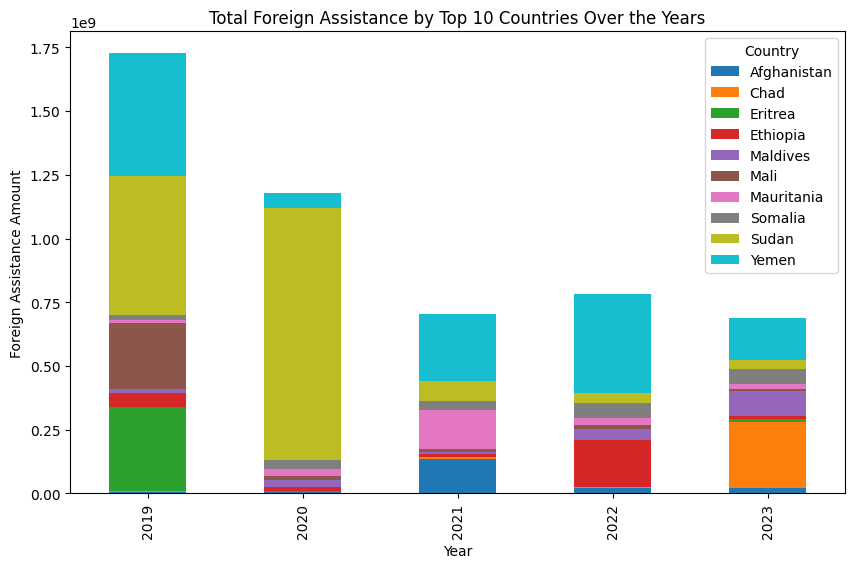

In [54]:
top_countries = ldc_df.groupby("Country")["Foreign Assistance (USD)"].sum().nlargest(10).index
df_top_countries = ldc_df[ldc_df["Country"].isin(top_countries)]

# Pivot data for stacked bar chart
pivot_df = df_top_countries.pivot_table(index="Year", columns="Country", values="Foreign Assistance (USD)", aggfunc="sum")

# Plot
pivot_df.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Total Foreign Assistance by Top 10 Countries Over the Years")
plt.xlabel("Year")
plt.ylabel("Foreign Assistance Amount")
plt.legend(title="Country")
plt.show()


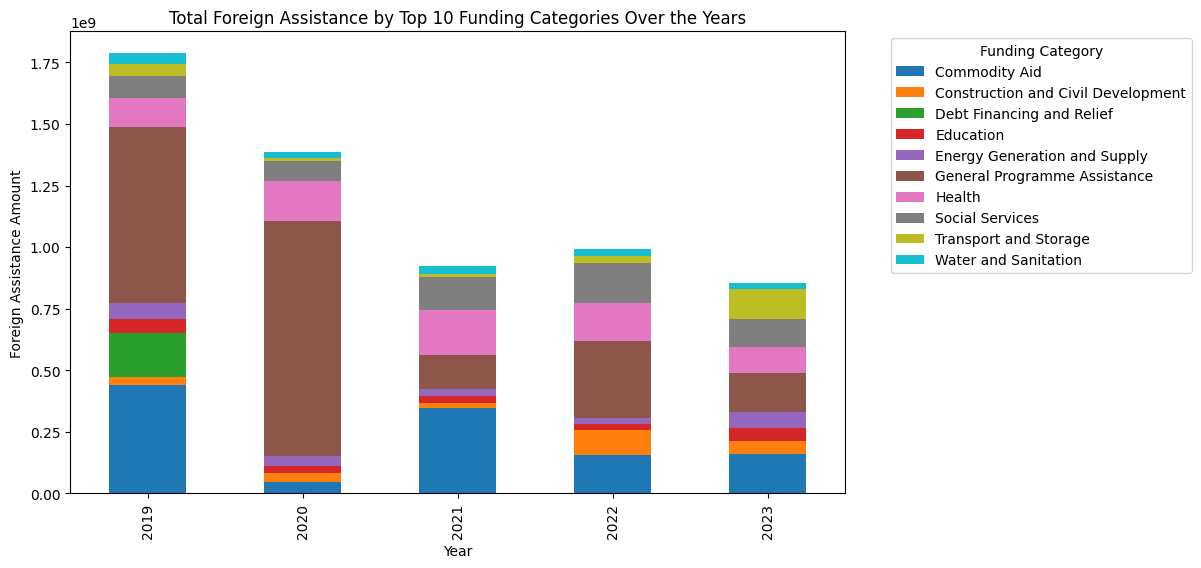

In [55]:
# Get top 10 funding categories by total Foreign Assistance
top_categories = ldc_df.groupby("Funding Category")["Foreign Assistance (USD)"].sum().nlargest(10).index
df_top_categories = ldc_df[ldc_df["Funding Category"].isin(top_categories)]

# Pivot data for stacked bar chart
pivot_df_category = df_top_categories.pivot_table(index="Year", columns="Funding Category", values="Foreign Assistance (USD)", aggfunc="sum")

# Plot
pivot_df_category.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Total Foreign Assistance by Top 10 Funding Categories Over the Years")
plt.xlabel("Year")
plt.ylabel("Foreign Assistance Amount")
plt.legend(title="Funding Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()